In [1]:
!pip install comet_ml --quiet

In [2]:
import comet_ml
COMET_API_KEY="VAmCb9Ijzw1NVa1ODQGoTJGtQ"

In [3]:
import tensorflow as tf
!pip install matplotlib --quiet
!pip install opencv-python --quiet

In [4]:
import matplotlib.pyplot as plt
!pip install mitdeeplearning --quiet
!pip install scipy --quiet
import mitdeeplearning as mdl

In [5]:
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write

In [6]:
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"

In [7]:
from mitdeeplearning import lab1
songs = lab1.load_training_data()
print("songs type is {}".format(type(songs)))
# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(type(example_song))
print(example_song)

Found 817 songs in text
songs type is <class 'list'>

Example song: 
<class 'str'>
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [8]:
# Convert the ABC notation to audio file and listen to it
!pip install music21 --quiet
from music21 import converter, stream
score = converter.parse(example_song, format='abc')

# Play the score
score.show('midi')

In [9]:
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [10]:
import numpy as np
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [11]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [12]:
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, "'": 5, '(': 6, ')': 7, ',': 8, '-': 9, '.': 10, '/': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, '<': 23, '=': 24, '>': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '^': 54, '_': 55, 'a': 56, 'b': 57, 'c': 58, 'd': 59, 'e': 60, 'f': 61, 'g': 62, 'h': 63, 'i': 64, 'j': 65, 'k': 66, 'l': 67, 'm': 68, 'n': 69, 'o': 70, 'p': 71, 'q': 72, 'r': 73, 's': 74, 't': 75, 'u': 76, 'v': 77, 'w': 78, 'x': 79, 'y': 80, 'z': 81, '|': 82}


In [13]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

# def vectorize_string(string):
  # TODO

vectorized_songs = vectorize_string(songs_joined)

In [14]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
print(tf.rank(vectorized_songs).numpy())
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"


'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]
1


In [15]:
def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  #print(len(vectorized_songs))
  #print(batch_size)
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)
  #print(idx)
  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  # input_batch = # TODO
  print(input_batch)
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  # output_batch = # TODO
  print(output_batch)

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not lab1.test_batch_func_types(get_batch, test_args) or \
   not lab1.test_batch_func_shapes(get_batch, test_args) or \
   not lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")

[array([30, 26, 26, 32,  1, 30, 29, 30, 31, 82]), array([29, 14,  1, 29, 14, 22, 82,  2,  0,  0])]
[array([26, 26, 32,  1, 30, 29, 30, 31, 82, 32]), array([14,  1, 29, 14, 22, 82,  2,  0,  0, 49])]
[PASS] test_batch_func_types
[array([59, 60, 61,  1, 62, 61, 62, 60, 82, 59]), array([59, 54, 58, 59, 82, 60, 56, 56, 62,  1])]
[array([60, 61,  1, 62, 61, 62, 60, 82, 59, 58]), array([54, 58, 59, 82, 60, 56, 56, 62,  1, 60])]
[PASS] test_batch_func_shapes
[array([14, 82, 26, 16,  1, 58, 14, 82,  2,  0]), array([ 1, 59, 14, 59, 60, 82, 61, 62, 56, 61])]
[array([82, 26, 16,  1, 58, 14, 82,  2,  0, 27]), array([59, 14, 59, 60, 82, 61, 62, 56, 61,  1])]
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [16]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

[array([82,  2,  0,  0, 49])]
[array([ 2,  0,  0, 49, 22])]
Step   0
  input: 82 ('|')
  expected output: 2 ('!')
Step   1
  input: 2 ('!')
  expected output: 0 ('\n')
Step   2
  input: 0 ('\n')
  expected output: 0 ('\n')
Step   3
  input: 0 ('\n')
  expected output: 49 ('X')
Step   4
  input: 49 ('X')
  expected output: 22 (':')


In [17]:
def LSTM(rnn_units):
    return tf.keras.layers.LSTM(rnn_units,
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform',
                                recurrent_activation='sigmoid',
                                stateful=True,)
    

In [18]:
def build_model(vocab_size,embedding_dim,rnn_units,batch_size):
    model=tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
                               LSTM(rnn_units),
                               tf.keras.layers.Dense(vocab_size)])
    return model
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [20]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
#print(y.shape)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

[array([61, 59, 60, 82, 61, 15, 60,  1, 59, 60, 61, 60, 82, 59, 27, 26, 31,
        1, 29, 14, 22, 82,  2,  0,  0, 49, 22, 14, 17, 17,  0, 45, 22, 38,
       76, 74, 64, 58, 56, 67,  1, 41, 73, 64, 60, 74, 75,  0, 51, 22,  1,
       64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 14, 15, 17,  0, 38, 22,
       28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 27,  1, 29, 70, 73, 64, 56,
       69,  0, 27, 26, 82, 31, 27, 27, 26,  1, 27, 15, 59, 82, 58]), array([82,  2,  0,  0, 49, 22, 13, 21,  0, 45, 22, 31, 70, 73, 75, 80,  9,
       45, 78, 70,  1, 41, 70, 76, 69, 59,  1, 28, 63, 60, 72, 76, 60,  0,
       51, 22,  1, 64, 59, 22, 59, 58,  9, 71, 70, 67, 66, 56,  9, 16, 15,
        0, 38, 22, 14, 11, 16,  0, 37, 22, 13, 11, 20,  0, 36, 22, 29,  1,
       38, 56, 65, 70, 73,  0, 59, 11, 27, 11, 82, 26, 59,  1, 27, 59, 11,
       27, 11, 82, 26, 29,  1, 31, 26, 82, 32, 30,  1, 27, 30, 82]), array([62, 82,  2,  0, 60, 27, 27, 14,  1, 60, 62, 61, 62, 82, 60, 27, 27,
       14,  1, 59, 60, 61, 62, 82, 5

In [21]:
#print(pred[0])
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
#print(sampled_indices)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([ 0, 79, 77, 79,  9, 54, 60, 64, 45,  3, 30, 48, 79, 59, 20, 73, 55,
       35, 45,  6, 67,  5, 23, 48,  6, 41, 10, 12, 33, 35, 57, 12, 59, 80,
       72, 23, 67, 30, 39, 82, 19, 80, 59, 77, 59, 63, 12,  4, 77, 33,  2,
       16,  3, 31, 55, 70, 31, 16, 18, 19, 41, 72, 44, 33, 51,  1, 60, 82,
       37, 16, 68, 68, 44, 49, 57, 51, 44, 75, 59, 82, 14,  9,  7,  9, 67,
       50, 77,  3, 76, 10, 36,  2, 82, 77, 78, 49, 38, 69, 46, 65],
      dtype=int64)

In [22]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'fde|f3e defe|dBAF D2:|!\n\nX:255\nT:Musical Priest\nZ: id:dc-reel-235\nM:C\nL:1/8\nK:B Dorian\nBA|FBBA B3d|c'

Next Char Predictions: 
 '\nxvx-^eiT"EWxd8r_JT(l\'<W(P.0HJb0dyq<lEN|7ydvdh0#vH!4"F_oF467PqSHZ e|L4mmSXbZStd|2-)-lYv"u.K!|vwXMnUj'


In [23]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss
example_batch_loss = compute_loss(y, pred)
print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.417972


In [24]:
vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [25]:
def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

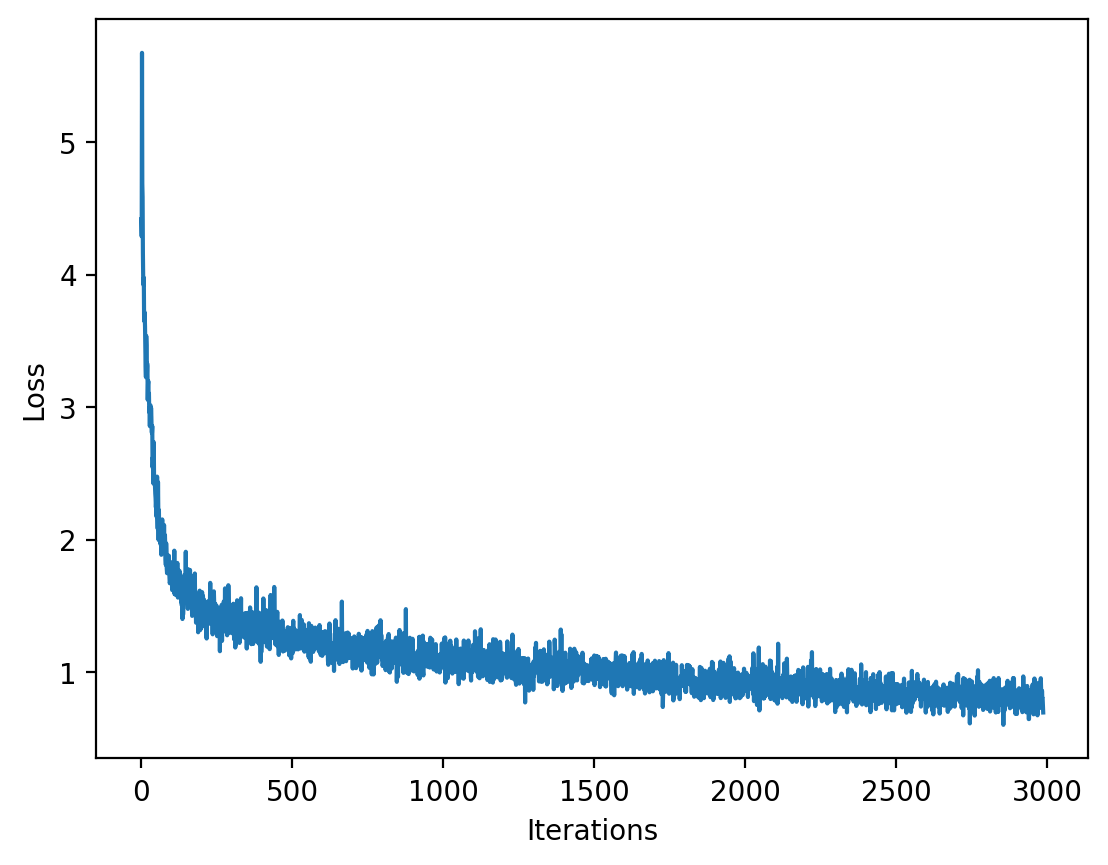

100%|█████████████████████████████████████████████████████████████████████████████▋| 2990/3000 [05:23<00:00, 14.02it/s]

[array([14,  1, 57, 62, 62, 14, 82, 56, 62, 61, 56,  1, 62, 60, 59, 27, 82,
       32, 14, 27, 32,  1, 59, 32, 27, 32, 82, 26, 32, 31, 26,  1, 32, 14,
       82, 53,  2,  0,  0, 49, 22, 14, 21, 15,  0, 45, 22, 41, 64, 69, 58,
       63,  1, 70, 61,  1, 44, 69, 76, 61, 61,  0, 51, 22,  1, 64, 59, 22,
       59, 58,  9, 73, 60, 60, 67,  9, 14, 19, 15,  0, 38, 22, 28,  0, 37,
       22, 13, 11, 20,  0, 36, 22, 29,  1, 38, 64, 79, 70, 67, 80]), array([62, 61, 60, 62,  1, 61, 59, 59, 82, 53,  2,  0,  0, 49, 22, 14, 14,
       19,  0, 45, 22, 38, 58, 31, 56, 59, 59, 60, 69,  5, 74,  1, 33, 56,
       69, 59, 74, 70, 68, 60,  1, 29, 56, 76, 62, 63, 75, 60, 73,  0, 51,
       22,  1, 64, 59, 22, 59, 58,  9, 73, 60, 60, 67,  9, 14, 12, 20,  0,
       38, 22, 28,  0, 37, 22, 13, 11, 20,  0, 36, 22, 26,  1, 38, 56, 65,
       70, 73,  0, 30, 15, 31,  1, 26, 14, 58, 26, 82, 27, 26, 27]), array([59,  1, 61, 59, 58, 59, 82, 62, 59, 61, 59,  1, 58, 59, 62, 59, 82,
       61, 59, 59, 59,  1, 59, 15, 2

100%|█████████████████████████████████████████████████████████████████████████████▊| 2994/3000 [05:23<00:00, 15.32it/s]

[array([ 1, 32, 30, 29, 30, 82, 32, 14, 32, 26,  1, 27, 59, 60, 61, 82, 62,
       61, 60, 59,  1, 27, 14, 26, 27, 82, 59, 27,  1,  6, 15, 26, 27, 26,
        1, 32, 14, 32, 14, 82, 32, 18, 22, 82,  2,  0, 26, 14, 82, 27, 59,
       60, 61,  1, 62, 14, 61, 62, 82, 56, 62, 61, 62,  1, 60, 15, 61, 82,
       61, 60, 59, 27,  1, 59, 27, 26, 27, 82, 59, 14, 59, 60,  1, 59, 14,
       60, 61, 82,  2,  0, 62, 14, 62, 56,  1, 62, 61, 60, 59, 82]), array([73, 60, 60, 67,  9, 14, 18, 16,  0, 38, 22, 28,  0, 37, 22, 13, 11,
       20,  0, 36, 22, 32,  1, 38, 56, 65, 70, 73,  0, 29, 32, 32, 14,  1,
       27, 32, 26, 31, 82, 29, 32, 32, 31,  1, 32, 29, 27,  8, 29, 82, 29,
       32, 32, 31,  1, 32, 26, 27, 58, 82, 59, 61, 60, 62,  1, 61, 59, 58,
       26, 82,  2,  0, 27, 32, 32, 14,  1, 27, 32, 26, 31, 82, 29, 32, 32,
       31,  1, 32, 29, 27,  8, 32,  8, 82, 26,  8, 27,  8, 28, 29]), array([ 1, 29, 70, 73, 64, 56, 69,  0, 30, 26,  1, 26, 27, 82, 58, 59,  1,
       60, 14, 82, 32, 25, 31,  1, 3

100%|█████████████████████████████████████████████████████████████████████████████▉| 2998/3000 [05:23<00:00, 16.36it/s]

[array([82, 27, 26,  1, 31, 27, 82, 26, 31,  1, 30, 31, 82, 29, 14,  1, 29,
       14, 22, 82,  2,  0, 59, 14,  1, 60, 14, 82, 61, 15, 61, 82, 60, 59,
        1, 27, 58, 82, 59, 15,  1, 26, 82,  2,  0, 27, 59, 11, 27, 11,  1,
       26, 31, 82, 27, 59, 11, 27, 11,  1, 26, 31, 82, 26, 31,  1, 30, 31,
       82, 29, 14,  1, 29, 14, 22, 82,  2,  0,  0, 49, 22, 15, 18,  0, 45,
       22, 39, 60, 78, 68, 56, 73, 66, 60, 75,  0, 51, 22,  1, 64]), array([51, 22,  1, 64, 59, 22, 59, 58,  9, 71, 70, 67, 66, 56,  9, 13, 15,
        0, 38, 22, 14, 11, 16,  0, 37, 22, 13, 11, 20,  0, 36, 22, 26,  1,
       38, 56, 65, 70, 73,  0, 60, 61, 11, 60, 11,  1, 58, 60, 82, 26, 60,
        1, 58, 60, 82, 61, 11, 62, 11, 56, 11, 61, 11,  1, 60, 58, 82, 27,
       26,  1, 31, 14, 82,  2,  0, 60, 61, 11, 60, 11,  1, 58, 60, 82, 26,
       60,  1, 58, 60, 82, 61, 11, 62, 11, 56, 11, 61, 11,  1, 60]), array([27, 59, 62, 82, 60, 14, 58, 26,  1, 31, 32, 26, 62, 82, 61, 14, 60,
       59,  1, 54, 58, 59, 60, 62, 8

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [05:23<00:00,  9.26it/s]
COMET INFO: Uploading 307 metrics, params and output messages


True

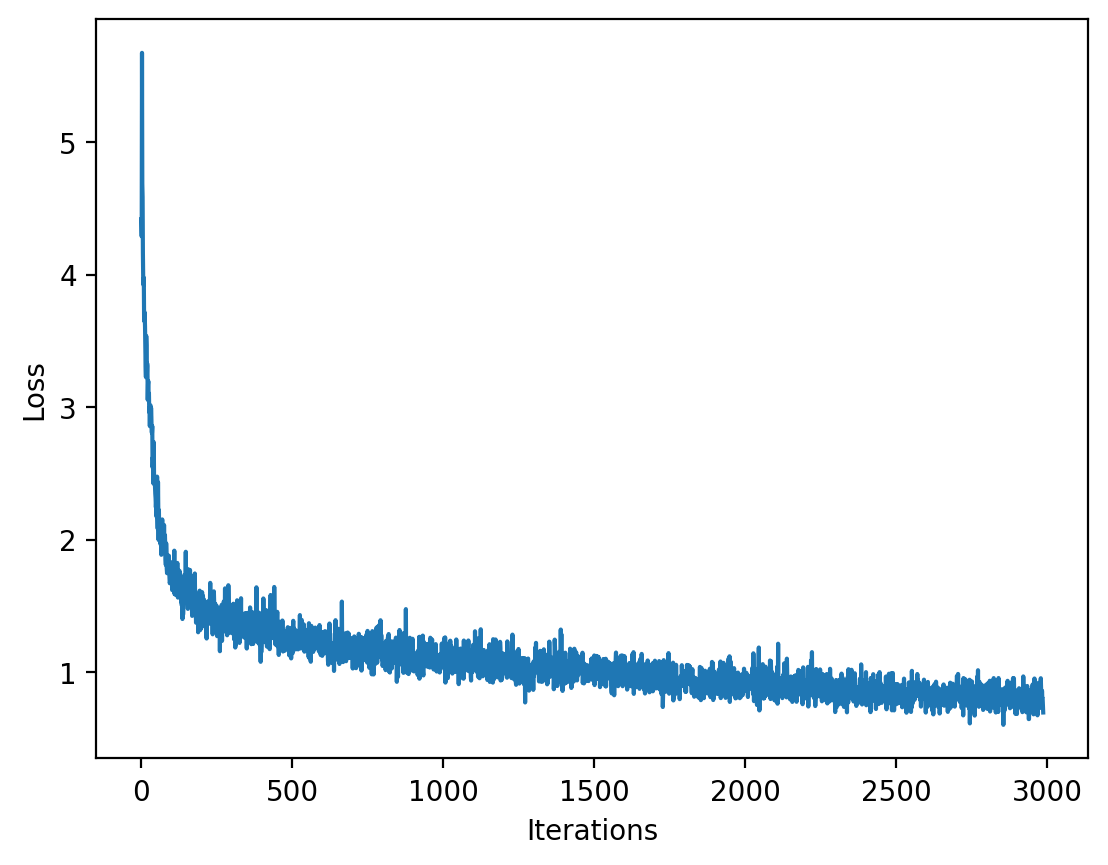

In [26]:
model = build_model(vocab_size, params["embedding_dim"], params["rnn_units"], params["batch_size"])
optimizer = tf.keras.optimizers.Adam(params["learning_rate"])
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x) 
        loss = compute_loss(y, y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss
history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear()
for iter in tqdm(range(params["num_training_iterations"])):
  x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)
  experiment.log_metric("loss", loss.numpy().mean(), step=iter)
  history.append(loss.numpy().mean())
  plotter.plot(history)
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)
model.save_weights(checkpoint_prefix)
experiment.flush()

In [27]:
model = build_model(vocab_size, params["embedding_dim"], params["rnn_units"], batch_size=1) # TODO
# model = build_model('''TODO''', '''TODO''', '''TODO''', batch_size=1)

# Restore the model weights for the last checkpoint after training
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [42]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval = [char2idx[s] for s in start_string] # TODO
  # input_eval = ['''TODO''']
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # predictions = model('''TODO''')

      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()

      # Pass the prediction along with the previous hidden state
      #   as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)

      '''TODO: add the predicted character to the generated text!'''
      # Hint: consider what format the prediction is in vs. the output
      text_generated.append(idx2char[predicted_id]) # TODO
      # text_generated.append('''TODO''')

  return (start_string + ''.join(text_generated))

In [72]:
generated_text = generate_text(model, start_string="X", generation_length=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 47.85it/s]


In [71]:
!pip install music21 pydub 
from music21 import converter
from pydub import AudioSegment
from pydub.generators import Sine

In [73]:
generated_songs = lab1.extract_song_snippet(generated_text)
print(generated_songs[0])

Found 7 songs in text
X:13
T:Aiming
Z: id:dc-jig-91
M:6/8
L:1/8
K:A Dorian
EBB2 BDAD|E2AE BAdA|BdAG FDEF|ABcd efge|dBAB G2:|!


In [78]:
def synthesize_abc_songs(abc_songs):
    """Synthesize a list of ABC songs into audio files."""
    for i, abc_notation in enumerate(abc_songs):
        try:
            score = converter.parse(abc_notation, format='abc')  # Parse ABC notation
            waveform = synthesize_waveform(score)
            if waveform:
                print("Generated song", i)
                ipythondisplay.display(waveform)
                print("hi2")
                numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
                wav_file_path = f"output_{i}.wav"
                write(wav_file_path, 88200, numeric_data)
                experiment.log_asset(wav_file_path)
                experiment.log_audio(wav_file_path)
        except Exception as e:
            print(f"Error processing song {i + 1}: {e}")

def synthesize_waveform(score):
    """Synthesize audio from a music21 score."""
    waveform = AudioSegment.silent(duration=0)  # Start with an empty audio segment

    for note in score.flat.notes:
        frequency = note.pitch.frequency
        duration = note.quarterLength * 1000  # Convert duration to milliseconds
        sine_wave = Sine(frequency).to_audio_segment(duration=duration)
        waveform += sine_wave  # Append the sine wave to the total waveform

    return waveform

In [79]:
synthesize_abc_songs(generated_songs)

Generated song 0


hi2
Error processing song 1: 'AudioSegment' object has no attribute 'data'
Generated song 1


hi2
Error processing song 2: 'AudioSegment' object has no attribute 'data'
Generated song 2


hi2
Error processing song 3: 'AudioSegment' object has no attribute 'data'
Error processing song 4: no active default note length provided for note processing. tPrev: <music21.abcFormat.ABCMetadata 'X:K:D Mixolydian'>, token: <music21.abcFormat.ABCNote 'D'>, tNext: <music21.abcFormat.ABCNote 'D2'>
Error processing song 5: no active default note length provided for note processing. tPrev: <music21.abcFormat.ABCMetadata 'X:K:D Mixolydian'>, token: <music21.abcFormat.ABCNote 'D'>, tNext: <music21.abcFormat.ABCNote 'D2'>
Generated song 5


hi2
Error processing song 6: 'AudioSegment' object has no attribute 'data'
Generated song 6


hi2
Error processing song 7: 'AudioSegment' object has no attribute 'data'


In [66]:
!pip install music21 --quiet
e1=generated_songs[0]
from music21 import converter, stream
score1 = converter.parse(e1, format='abc')
# Play the score


In [68]:
e2=generated_songs[3]
from music21 import converter, stream
score2 = converter.parse(e2, format='abc')
# Play the score
score2.show('midi')

In [ ]:
from music21 import converter
from pydub import AudioSegment
from pydub.generators import Sine